# Calculating the Bilingual Evaluation Understudy (BLEU) score: Ungraded Lab

In this ungraded lab, we will implement a popular metric for evaluating the quality of machine-translated text: the BLEU score proposed by Kishore Papineni, et al. In their 2002 paper ["BLEU: a Method for Automatic Evaluation of Machine Translation"](https://www.aclweb.org/anthology/P02-1040.pdf), the BLEU score works by comparing "candidate" text to one or more "reference" translations. The result is better the closer the score is to 1. Let's see how to get this value in the following sections.

# Part 1:  BLEU Score

## 1.1  Importing the Libraries

We will first start by importing the Python libraries we will use in the first part of this lab. For learning, we will implement our own version of the BLEU Score using Numpy. To verify that our implementation is correct, we will compare our results with those generated by the [SacreBLEU library](https://github.com/mjpost/sacrebleu). This package provides hassle-free computation of shareable, comparable, and reproducible BLEU scores. It also knows all the standard test sets and handles downloading, processing, and tokenization.

In [16]:
import numpy as np                  # import numpy to make numerical computations.
import nltk                         # import NLTK to handle simple NL tasks like tokenization.
from nltk.util import ngrams
nltk.download('punkt')
import math
from collections import Counter     # import the Counter module.
!pip3 install 'sacrebleu'           # install the sacrebleu package.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.
import matplotlib.pyplot as plt     # import pyplot in order to make some illustrations.

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


## 1.2  Defining the BLEU Score

You have seen the formula for calculating the BLEU score in this week's lectures. More formally, we can express the BLEU score as:

$$BLEU = BP\Bigl(\prod_{i=1}^{4}precision_i\Bigr)^{(1/4)}$$

with the Brevity Penalty and precision defined as:

$$BP = min\Bigl(1, e^{(1-({ref}/{cand}))}\Bigr)$$

$$precision_i = \frac {\sum_{snt \in{cand}}\sum_{i\in{snt}}min\Bigl(m^{i}_{cand}, m^{i}_{ref}\Bigr)}{w^{i}_{t}}$$

where:

* $m^{i}_{cand}$, is the count of i-gram in candidate matching the reference translation.
* $m^{i}_{ref}$, is the count of i-gram in the reference translation.
* $w^{i}_{t}$, is the total number of i-grams in candidate translation.

## 1.3 Explaining the BLEU score

### Brevity Penalty (example):

In [11]:
ref_length = np.ones(100)
can_length = np.linspace(1.5, 0.5, 100)
x = ref_length / can_length
y = 1 - x

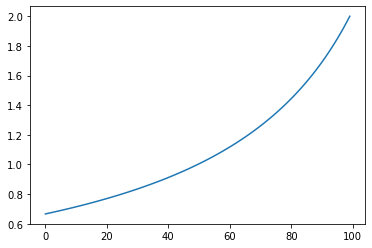

In [12]:
plt.plot(x)

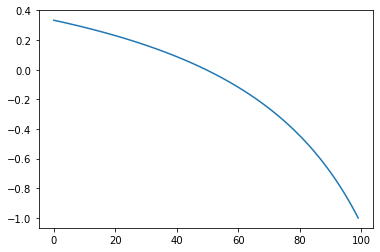

In [13]:
plt.plot(y)

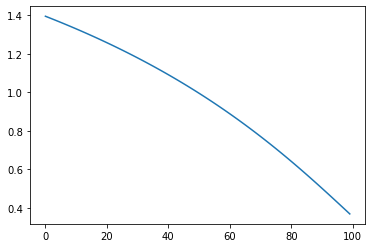

In [14]:
plt.plot(np.exp(y))

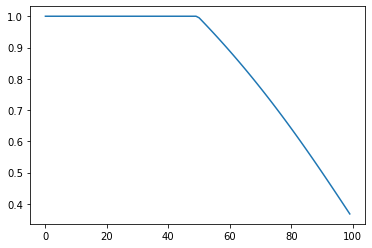

In [15]:
plt.plot(np.minimum(np.ones(y.shape), np.exp(y)))

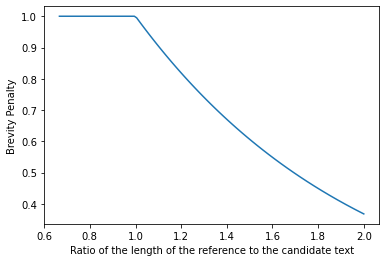

In [4]:
ref_length = np.ones(100)
can_length = np.linspace(1.5, 0.5, 100)
x = ref_length / can_length
y = 1 - x
y = np.exp(y)
y = np.minimum(np.ones(y.shape), y)

# Code for in order to make the plot
fig, ax = plt.subplots(1)
lines = ax.plot(x, y)
ax.set(
    xlabel="Ratio of the length of the reference to the candidate text",
    ylabel="Brevity Penalty",
)
plt.show()

The brevity penalty penalizes generated translations that are too short compared to the closest reference length with an exponential decay. The brevity penalty compensates for the fact that the BLEU score has no recall term.

### N-Gram Precision (example):

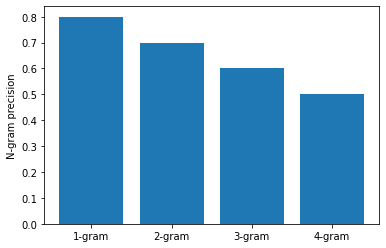

In [3]:
data = {"1-gram": 0.8, "2-gram": 0.7, "3-gram": 0.6, "4-gram": 0.5}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="N-gram precision")

plt.show()

The n-gram precision counts how many unigrams, bigrams, trigrams, and four-grams (i=1,...,4) match their n-gram counterpart in the reference translations. This term acts as a precision metric. Unigrams account for adequacy while longer n-grams account for fluency of the translation. To avoid overcounting, the n-gram counts are clipped to the maximal n-gram count occurring in the reference ($m_{n}^{ref}$). Typically precision shows exponential decay with the with the degree of the n-gram.

### N-gram BLEU score (example):

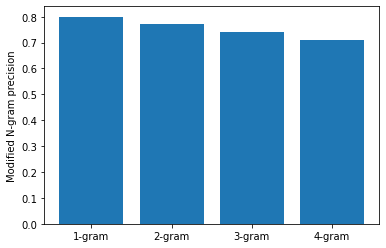

In [18]:
data = {"1-gram": 0.8, "2-gram": 0.77, "3-gram": 0.74, "4-gram": 0.71}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="Modified N-gram precision")

plt.show()

When the n-gram precision is multiplied by the BP, then the exponential decay of n-grams is almost fully compensated. The BLEU score corresponds to a geometric average of this modified n-gram precision.

## 1.4 Example Calculations of the BLEU score

In this example we will have a reference translation and 2 candidates translations. We will tokenize all sentences using the NLTK package introduced in Course 2 of this NLP specialization.

In [22]:
reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

The NASA Opportunity rover is battling a massive dust storm on planet Mars. -> ['the', 'nasa', 'opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'planet', 'mars', '.']


The Opportunity rover is combating a big sandstorm on planet Mars. -> ['the', 'opportunity', 'rover', 'is', 'combating', 'a', 'big', 'sandstorm', 'on', 'planet', 'mars', '.']


A NASA rover is fighting a massive storm on planet Mars. -> ['a', 'nasa', 'rover', 'is', 'fighting', 'a', 'massive', 'storm', 'on', 'planet', 'mars', '.']


### STEP 1: Computing the Brevity Penalty

In [97]:
def brevity_penalty(candidate, reference):
    ref_length = len(reference)
    can_length = len(candidate)

    # Brevity Penalty
    if ref_length < can_length: # if reference length is less than candidate length
        BP = 1 # set BP = 1
    else:
        penalty = 1 - (ref_length / can_length) # else set BP=exp(1-(ref_length/can_length))
        BP = np.exp(penalty)

    return BP

### STEP 2: Computing the Precision

In [92]:
def clipped_precision(candidate, reference):
    """
    Clipped precision function given a original and a machine translated sentences
    """

    clipped_precision_score = []
    
    for i in range(1, 5):
        ref_n_gram = Counter(ngrams(reference,i))
        cand_n_gram = Counter(ngrams(candidate,i))

        c = sum(cand_n_gram.values())
        
        for j in cand_n_gram: # for every n-gram up to 4 in candidate text
            if j in ref_n_gram: # check if it is in the reference n-gram
                if cand_n_gram[j] > ref_n_gram[j]: # if the count of the candidate n-gram is bigger
                                                   # than the corresponding count in the reference n-gram,
                    cand_n_gram[j] = ref_n_gram[j] # then set the count of the candidate n-gram to be equal
                                                   # to the reference n-gram
            else:
                cand_n_gram[j] = 0 # else set the candidate n-gram equal to zero

        clipped_precision_score.append(sum(cand_n_gram.values())/c)

    weights =[0.25]*4

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = math.exp(math.fsum(s))
    return s


### STEP 3: Computing the BLEU score

In [98]:
def bleu_score(candidate, reference):
    BP = brevity_penalty(candidate, reference)
    precision= clipped_precision(candidate, reference)
    return BP * precision

### STEP 4: Testing with our Example Reference and Candidates Sentences

In [99]:
print(
    "Results reference versus candidate 1 our own code BLEU: ",
    round(bleu_score(tokenized_cand_1, tokenized_ref) * 100, 1),
)
print(
    "Results reference versus candidate 2 our own code BLEU: ",
    round(bleu_score(tokenized_cand_2, tokenized_ref) * 100, 1),
)

Results reference versus candidate 1 our own code BLEU:  27.6
Results reference versus candidate 2 our own code BLEU:  35.3


### STEP 5: Comparing the Results from our Code with the SacreBLEU Library

In [100]:
print(
    "Results reference versus candidate 1 sacrebleu library BLEU: ",
    round(sacrebleu.corpus_bleu(candidate_1, reference).score, 1),
)
print(
    "Results reference versus candidate 2 sacrebleu library BLEU: ",
    round(sacrebleu.corpus_bleu(candidate_2, reference).score, 1),
)

Results reference versus candidate 1 sacrebleu library BLEU:  27.6
Results reference versus candidate 2 sacrebleu library BLEU:  35.3


# Part 2:  BLEU computation on a corpus

## Loading Data Sets for Evaluation Using the BLEU Score

In this section, we will show a simple pipeline for evaluating machine translated text. Due to storage and speed constraints, we will not be using our own model in this lab (you'll get to do that in the assignment!). Instead, we will be using [Google Translate](https://translate.google.com) to generate English to German translations and we will evaluate it against a known evaluation set. There are three files we will need:

1. A source text in English. In this lab, we will use the first 1671 words of the [wmt19](http://statmt.org/wmt19/translation-task.html) evaluation dataset downloaded via SacreBLEU. We just grabbed a subset because of limitations in the number of words that can be translated using Google Translate. 
2. A reference translation to German of the corresponding first 1671 words from the original English text. This is also provided by SacreBLEU.
3. A candidate machine translation to German from the same 1671 words. This is generated by feeding the source text to a machine translation model. As mentioned above, we will use Google Translate to generate the translations in this file.

With that, we can now compare the reference an candidate translation to get the BLEU Score.

In [103]:
# Loading the raw data
wmt19_src = open("wmt19_src.txt", "rU")
wmt19_src_1 = wmt19_src.read()
wmt19_src.close()
wmt19_ref = open("wmt19_ref.txt", "rU")
wmt19_ref_1 = wmt19_ref.read()
wmt19_ref.close()
wmt19_can = open("wmt19_can.txt", "rU")
wmt19_can_1 = wmt19_can.read()
wmt19_can.close()

tokenized_corpus_src = nltk.word_tokenize(wmt19_src_1.lower())
tokenized_corpus_ref = nltk.word_tokenize(wmt19_ref_1.lower())
tokenized_corpus_cand = nltk.word_tokenize(wmt19_can_1.lower())

Inspecting the first sentence of the data.

In [105]:
print("English source text:")
print("\n")
print(f"{wmt19_src_1[0:170]} -> {tokenized_corpus_src[0:30]}")
print("\n")
print("German reference translation:")
print("\n")
print(f"{wmt19_ref_1[0:219]} -> {tokenized_corpus_ref[0:35]}")
print("\n")
print("German machine translation:")
print("\n")
print(f"{wmt19_can_1[0:199]} -> {tokenized_corpus_cand[0:29]}")

English source text:


﻿Welsh AMs worried about 'looking like muppets'
There is consternation among some AMs at a suggestion their title should change to MWPs (Member of the Welsh Parliament).
 -> ['\ufeffwelsh', 'ams', 'worried', 'about', "'looking", 'like', "muppets'", 'there', 'is', 'consternation', 'among', 'some', 'ams', 'at', 'a', 'suggestion', 'their', 'title', 'should', 'change', 'to', 'mwps', '(', 'member', 'of', 'the', 'welsh', 'parliament', ')', '.']


German reference translation:


﻿Walisische Ageordnete sorgen sich "wie Dödel auszusehen"
Es herrscht Bestürzung unter einigen Mitgliedern der Versammlung über einen Vorschlag, der ihren Titel zu MWPs (Mitglied der walisischen Parlament) ändern soll.
 -> ['\ufeffwalisische', 'ageordnete', 'sorgen', 'sich', '``', 'wie', 'dödel', 'auszusehen', "''", 'es', 'herrscht', 'bestürzung', 'unter', 'einigen', 'mitgliedern', 'der', 'versammlung', 'über', 'einen', 'vorschlag', ',', 'der', 'ihren', 'titel', 'zu', 'mwps', '(', 'mitglied', 'd

In [106]:
print(
    "Results reference versus candidate 1 our own BLEU implementation: ",
    round(bleu_score(tokenized_corpus_cand, tokenized_corpus_ref) * 100, 1),
)

Results reference versus candidate 1 our own BLEU implementation:  43.6


In [107]:
print(
    "Results reference versus candidate 1 sacrebleu library BLEU: ",
    round(sacrebleu.corpus_bleu(wmt19_can_1, wmt19_ref_1).score, 1),
)

Results reference versus candidate 1 sacrebleu library BLEU:  43.2


**BLEU Score Interpretation on a Corpus**

|Score      | Interpretation                                                |
|:---------:|:-------------------------------------------------------------:|
| < 10      | Almost useless                                                |
| 10 - 19   | Hard to get the gist                                          |
| 20 - 29   | The gist is clear, but has significant grammatical errors     |
| 30 - 40   | Understandable to good translations                           |
| 40 - 50   | High quality translations                                     |
| 50 - 60   | Very high quality, adequate, and fluent translations          |
| > 60      | Quality often better than human                               |

From the table above (taken [here](https://cloud.google.com/translate/automl/docs/evaluate)), we can see the translation is high quality (*if you see "Hard to get the gist", please open your workspace, delete `wmt19_can.txt` and get the latest version via the Lab Help button*). Moreover, the results of our coded BLEU score are almost identical to those of the SacreBLEU package.